In [1]:
import transformers
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import re
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

2021-10-13 06:32:19.188870: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from kaggle_secrets import UserSecretsClient
import wandb
from wandb.keras import WandbCallback
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-api-key") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
config = dict(
    epochs=2,
    classes=2,
    batch_size=16,
    max_length=120,
    learning_rate=1e-5,
    architecture="Transformer",
    model_name="Roberta",
    pre_trained_model_name="roberta-base"
)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [6]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [7]:
import re
from nltk.tokenize import WordPunctTokenizer
# import emoji
from bs4 import BeautifulSoup
import itertools

tok = WordPunctTokenizer()

pattern1 = r'@[A-Za-z0-9]+'
pattern2 = r'https?://[A-Za-z0-9./]+'

def tweet_cleaner(text): # ref: https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
    # removing UTF-8 BOM (Byte Order Mark)
    text = text.lower()
    
    try:
        text1 = text.decode("utf-8-sig").replace(u"\ufffd", "?") # The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8
    except:
        text1 = text
    
    
    #replace consecutive non-ASCII characters with a space
    text1 = re.sub(r'[^\x00-\x7F]+',' ', text1)
    
    #remove emojis from tweet
    text2 = emoji_pattern.sub(r'', text1)
    
    # Remove emoticons
    # text3 = [word for word in text2.split() if word not in emoticons]
    # text3 = " ".join(text3)
    
    # contradictions and special characters 
    # text4 = spl_ch_contra(text3)
    
    # HTML encoding
    soup = BeautifulSoup(text2, 'lxml') #HTML encoding has not been converted to text, and ended up in text field as ‘&amp’,’&quot’,etc.
    text5 = soup.get_text()
    
    # removing @ mentions
    text6 = re.sub(pattern1, '', text5)
    
    # Removing URLs
    text7 = re.sub(pattern2, '', text6)
    
#     Removing punctuations
    text8 = re.sub("[\.\,\!\?\:\;\-\=\(\)\[\]\"\'\%\*\#\@><]", " ", text7)
    
    # Tokenizing ,change cases & join together to remove unneccessary white spaces
    text7_list = tok.tokenize(text8)
    text10 = (" ".join(text7_list)).strip()
    
    return text10

In [8]:
train_data['text'] = list(map(lambda x:tweet_cleaner(x),train_data['text']))


In [9]:
print(train_data.shape)
print(test_data.shape)

(7613, 5)
(3263, 4)


In [10]:
train_data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
test_data.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


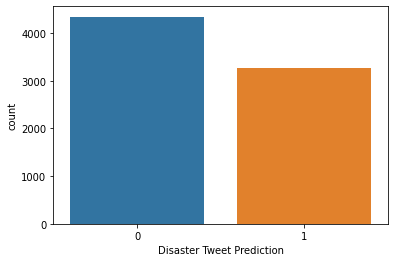

In [12]:
sns.countplot(train_data['target'])
plt.xlabel('Disaster Tweet Prediction');

In [13]:
tokenizer = RobertaTokenizer.from_pretrained(config['pre_trained_model_name'])

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Number of tokens')

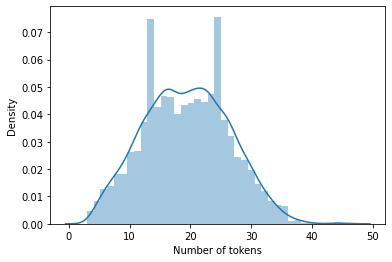

In [14]:
token_length = []

for entry in train_data['text']:
    tokens = tokenizer.encode(entry, max_length = 512) #max number of tokens in BERT cannot exceed 512
    token_length.append(len(tokens))
    

sns.distplot(token_length)
plt.xlabel('Number of tokens')

In [15]:
class DisasterTweetDataSet(Dataset):
    def __init__(self, text, target, tokenizer, max_length):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.text)
        
    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.target[item]
        
        #encoding returns a dictionary with 2 keys (input_ids, attention_mask)
        encoding = self.tokenizer.encode_plus (
          text,
          add_special_tokens=True, # Add '[CLS]' and '[SEP]'
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt', # Return PyTorch tensors
        )
        
        return {
            'tweet' : text,
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
            'targets' : torch.tensor(target, dtype = torch.long)
        }

In [16]:
df_train, df_val = train_test_split(
    train_data,
    test_size = 0.2,
    random_state = 42
)

In [17]:
print(df_train.shape)
print(df_val.shape)

(6090, 5)
(1523, 5)


In [18]:
def create_data_loader(df, tokenizer, max_length, batch_size):
    dataset = DisasterTweetDataSet(
                df['text'].to_numpy(),
                df['target'].to_numpy(),
                tokenizer,
                max_length = max_length
            )
    
    return DataLoader(
        dataset,
        batch_size = batch_size,
        num_workers = 4
    )

In [19]:
class DisasterTweetClassifier(nn.Module):
    def __init__(self,  config):
        super(DisasterTweetClassifier, self).__init__()
        self.robert = RobertaModel.from_pretrained(config['pre_trained_model_name'])
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.robert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.robert(
          input_ids=input_ids,
          attention_mask=attention_mask,
        return_dict = False
        )
        
        output = self.drop(pooled_output)
        return self.out(output)

In [20]:
def train_epoch(
        model,
        data_loader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        n_examples,
       ):
    model.train()
    wandb.watch(model, loss_fn, log="all", log_freq=10)
    losses = []
    correct_predictions = 0
    
    for data in data_loader:                   
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)
        
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        
        _, preds = torch.max(outputs, dim = 1)
        
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        
        losses.append(loss.item())
        
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
                       
    return correct_predictions.double()/n_examples, np.mean(losses)

In [21]:
def eval_epoch(
        model,
        data_loader,
        loss_fn,
        device,
        n_examples
):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["targets"].to(device)
            
            outputs = model(
             input_ids=input_ids,
            attention_mask=attention_mask
            ) 
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
            accuracy = correct_predictions.double()/n_examples

            
        return accuracy, np.mean(losses)

In [22]:
def plot_accuracy(history):
    plt.plot(history['train_acc'], label = 'training accuracy')
    plt.plot(history['val_acc'], label = 'validation accuracy')

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training History")

In [23]:
class PredictTestDataset(Dataset):
    def __init__(self, text,tokenizer, max_length):
        self.text = text
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.text)
        
    def __getitem__(self, item):
        text = str(self.text[item])
        
        #encoding returns a dictionary with 2 keys (input_ids, attention_mask)
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True, # Add '[CLS]' and '[SEP]'
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt', # Return PyTorch tensors
        )
        
        return {
            'tweet' : text,
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
        }

In [24]:
def create_test_data_loader(df, tokenizer, max_length, batch_size):
    dataset = PredictTestDataset(
                df['text'].to_numpy(),
                tokenizer,
                max_length = max_length
            )
    
    return DataLoader(
        dataset,
        batch_size = batch_size,
        num_workers = 4
    )

In [25]:
def predict(
        model,
        data_loader,
        device,
):
    model = model.eval()
    
    predictions = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            
            outputs = model(
             input_ids=input_ids,
            attention_mask=attention_mask
            ) 
            
            _, preds = torch.max(outputs, dim=1)

            for val in preds.tolist():
                predictions.append(val)
    
    return predictions

In [26]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

In [27]:
def generate_submission_csv(predictions):
    submission_df = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

    submission_df['id'] = test_data['id']
    submission_df['target'] = predictions
    
    sns.countplot(submission_df['target'])
    plt.xlabel('Disaster Tweet Test Prediction')
               
    submission_df.to_csv('roberta-base.csv', index = False)


In [28]:
def model_pipeline(hyperparameters):
    # tell wandb to get started
    
    with wandb.init(project="Disaster-Tweet-Prediction", group="roberta-base", config=hyperparameters):
    # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config
    
        train_data_loader = create_data_loader(df_train, tokenizer, config.max_length, config.batch_size)
        val_data_loader = create_data_loader(df_val, tokenizer, config.max_length, config.batch_size)
        
        model = DisasterTweetClassifier(config).to(device)
        
        optimizer = AdamW(model.parameters(), lr=config.learning_rate, correct_bias=False)

        total_steps = len(train_data_loader) * config.epochs

        scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=0,
          num_training_steps=total_steps
        )

        loss_fn = nn.CrossEntropyLoss().to(device)
        
        history = defaultdict(list)
        best_accuracy = 0
     
        for epoch in range(config.epochs):
            print(f'Epoch {epoch + 1}/{config.epochs}')
            print('-' * 10)

            train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, scheduler, 
                                                             device, len(df_train))

            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = eval_epoch(model, val_data_loader, loss_fn, device, len(df_val))

            print(f'Val   loss {val_loss} accuracy {val_acc}')

            wandb.log({
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Acc": train_acc,
            "Valid Loss": val_loss,
            "Valid Acc": val_acc})
            
            history['train_acc'].append(train_acc)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            if val_acc > best_accuracy:
                torch.save(model.state_dict(), 'bert_base_cased.bin')
                best_accuracy = val_acc
                    
        test_data_loader = create_test_data_loader(test_data, tokenizer, config['max_length'], config['batch_size'])
        
        predictions = predict(model, test_data_loader, device)
        
        generate_submission_csv(predictions)
    
    return model

wandb: Currently logged in as: kushv16 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-10-13 06:32:43.936755: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 1/2
----------
Train loss 0.4670897446709668 accuracy 0.797208538587849
Val   loss 0.37963726732414216 accuracy 0.8483256730137885
Epoch 2/2
----------
Train loss 0.35034559510667806 accuracy 0.8614121510673235
Val   loss 0.40148642713514465 accuracy 0.8371634931057124


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Epoch,1
Train Acc,0.86141
Train Loss,0.35035
Valid Acc,0.83716
Valid Loss,0.40149


Epoch,▁█
Train Acc,▁█
Train Loss,█▁
Valid Acc,█▁
Valid Loss,▁█


CPU times: user 16min 34s, sys: 2min 53s, total: 19min 28s
Wall time: 19min 52s


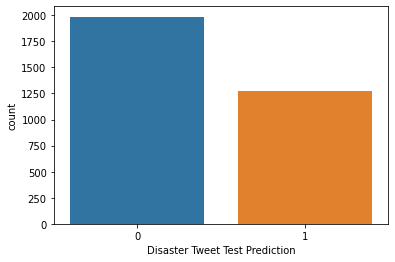

In [29]:
%%time
model = model_pipeline(config)